# Analyzing My Spotify Data

Payton Burks  
CPSC 222, Fall 2020  
17 December 2020

---

## Introduction

### Domain

This project deals with music and (my) listening statistics. I have loved listening to music since I was a kid, so I thought analyzing my listening habits would be insightful. Though I have no intention of ever creating music, it has played an important part of my development and will likely continue to do so. Hopefully I am able to glean some insights into what I listen to on a particular day, what artists I like the most, and how different my music taste is apart from others.

### Dataset

The raw data is imported as json files with 4 categories:
* endTime = date and time the song finished (formatted 'year-month-day hour:minute')
* artistName = artist
* trackName = song
* msPlayed = milliseconds played

I will be appending...
* day = day of the week
* skipped? = if the song was skipped (listened to for$\leq$30s)
* top100artist? = if the artist was in my top 100 most played artists

### Hypothesis Testing

I will be testing the following hypotheses:
* The average length of songs I listen to is shorter than the average length of hit songs worldwide 
* I listen to more music (per day, on average) on weekends than weekdays.
* I skip songs by my top 100 artists more often than songs by those who aren't on my top 100 list

### Stockholders

Personally, I am a huge stakeholder in these results; the information is fascinating to me. Additionally, due to the fact I am creating a model to see what makes my skips happen more often, these results could be huge to artists in the music industry. If they can get information on which of their songs were skipped more often, they may be able to turn a higher profit on their next project (assuming these results are reproduced with different streaming data).

### Classification

I will be using the "skipped?" category as my classification element. I will be trying to see if I can classify whether or not I skipped a song based on the other characteristics (not including msPlayed, as that directly correlates to skipping the song).

---

## Data Analysis

### Dataset Description

As previously noted, the raw data comes in as json files. In order to more easily manipulate my data, I loaded each one into a DataFrame and then merged them into one gigantic DataFrame.

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt

import utils

#load in data
data0 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory0.json")
data1 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory1.json")
data2 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory2.json")
data3 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory3.json")
data4 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory4.json")
data5 = utils.load_data("StreamingHistoryJsonFiles/StreamingHistory5.json")

#join all data into spot_df
spot_df = pd.concat([data0, data1, data2, data3, data4, data5], ignore_index=True)

As a reminder, there are four initial attributes to the data *(endTime*, *artistName*, *artist*, *trackName*, *msPlayed*). In-depth descriptions can be found above.

### Data Preparation

#### Data Cleaning

The only issue I had with computationally with the data was the '$' character found in artists such as Joey Bada$$ and A$AP Rocky, among others. This was causing problems, so I replaced '$' with 'S'.

Next, I had two tasks remaining. I had to replace "Unknown Artist" with "Playboi Carti" (Spotify was picking up my local files - which are all Playboi Carti song leaks - as "Unknown Artist") and remove the podcasts that I listened to. Finally, I could move the clean data to a csv file. The clean data can be viewed [here](https://raw.githubusercontent.com/paytonburks/SpotifyDataPayton/main/cleanspotifydata.csv).

In [18]:
#clean data   
utils.clean_spot_df(spot_df)
utils.rm_pod(spot_df)

spot_df = spot_df.reset_index(drop=True)

#data to csv
spot_df.to_csv("cleanspotifydata.csv")

#### Appending other data (and a little EDA)

As part of the preparation, I would be appending three new attributes (*day, skipped?, top100artist?*). Again, more in-depth descriptions of these attributes are found above. In order to find my top 100 artists for the corresponding attribute, I would have to compute a new dataframe which was composed of two columns, artist and hoursListened.
 
While preparing these attributes, I was also able to compute a few statistics and find out more information about the data. These are printed beneath some of the code that allowed me to create the new attributes.

##### *day*

In [19]:
#get dates from data
raw_dates = utils.get_date_list(spot_df)

#combine dates with findDay
day_of_week = []
for item in raw_dates:
    newEntry = utils.findDay(item)
    day_of_week.append(newEntry)

#append day_of_week to spot_df
spot_df["day"] = day_of_week

##### *skipped?*

In [20]:
#newvars
skipped = []
timeListen = spot_df["msPlayed"].copy()
numSkips = 0
totSongs = 0

#loop through data
for item in timeListen:
    secListened = item/1000
    if secListened < 30:
        skipped.append('y')
        numSkips += 1
        totSongs += 1
    else:
        skipped.append('n')
        totSongs += 1
        
#append data
spot_df["skipped?"] = skipped

print("Number of songs skipped:", numSkips)
print("Percent of songs skipped:", round((numSkips/totSongs),4)*100, '%')

Number of songs skipped: 11940
Percent of songs skipped: 21.01 %


##### *top100artist?*
**Must first create new DataFrame, artist X hours listened*

In [21]:
#new vars
bigtotal = 0
#vars for new DF
totalHours_perArtist = []
artist_perArtist = []
#grouping by artist
group_by_artist_df = spot_df.groupby("artistName")

for artist, group_df in group_by_artist_df:
    msplayed_ser = group_df["msPlayed"].copy()
    totalms = msplayed_ser.sum()
    totalhours = totalms/1000/60/60
    bigtotal += totalhours
    
    #data for new df for hours x artist
    totalHours_perArtist.append(round(totalhours, 2))
    artist_perArtist.append(artist)
    
artist_x_hours_df = utils.create_artist_x_hours_df(artist_perArtist, totalHours_perArtist)

print("Total hours spent listening:", round(bigtotal))
print("Total days spent listening:", round(bigtotal/24))

Total hours spent listening: 2175
Total days spent listening: 91


##### Actually creating *top100artist?* attribute

In [22]:
#new vars
top100YorN = []
artist_data = spot_df["artistName"].copy()
artist_data = artist_data.to_list()
top100 = artist_x_hours_df.iloc[0:101]["Artist"].copy()

#loop through data
for artist in artist_data:
    artistIsIn = False
    for item in top100:
        if item == artist:
            artistIsIn = True
            break
    if artistIsIn == True:
        top100YorN.append('y')
    else:
        top100YorN.append('n')
#append        
spot_df["top100Artist?"] = top100YorN

##### Convert new, fuller DataFrame to a new csv

In [23]:
spot_df.to_csv('finalspotifydata.csv')

The full DataFrame can be viewed [here](https://raw.githubusercontent.com/paytonburks/SpotifyDataPayton/main/finalspotifydata.csv).

### Exploratory Data Analysis

#### Data Visualization

I will be visualizing...
* An interactive list of all unique artists I listened to
* Top 100 graph of artists x hours listened (grouped by 10s)
* The percentage of hours I spent listening to my top 100 artists
* Graph displaying average hours spent per day listening to music

#### Interactive list of all artists

In [26]:
#get all names of artists
artist_name_list = []

#forming list
for artist, group_df in group_by_artist_df:
    artist_in_list = False
    for i in range(len(artist_name_list)):
        if(artist == artist_name_list[i]):
            artist_in_list == True
            
    if artist_in_list == False:
        artist_name_list.append(artist)

#write list to .txt file
text_file = open("ArtistList.txt", 'w')
for i in range(len(artist_name_list)):
    artist = str(artist_name_list[i])
    if artist == 'Yunggoth✰':
        artist = 'Yunggoth'
    if artist == "μ's":
        artist = "u's"
    text_file.write(artist + "\n")
text_file.close()

#interactive portion
print("Payton has listened to", len(artist_name_list), "unique artists over the past year.")
print("Search for an artist and receive back the number of hours Payton listened:")
find_artist = input()
print()

i=0
while i in range(len(artist_perArtist)):
    if artist_perArtist[i] == find_artist:
        print("Payton has listened to a total of", totalHours_perArtist[i],"hours of", find_artist)
        break
    i+=1
    if i == 1660:
        print("Payton has not listened to", find_artist)       

Payton has listened to 1660 unique artists over the past year.
Search for an artist and receive back the number of hours Payton listened:


 slowthai



Payton has listened to a total of 21.93 hours of slowthai


#### Top 100 Artists Graph

I will only be displaying the top 10 below. The other graphs can be viewed in the [Figures](www.clubpenguin.com) folder.

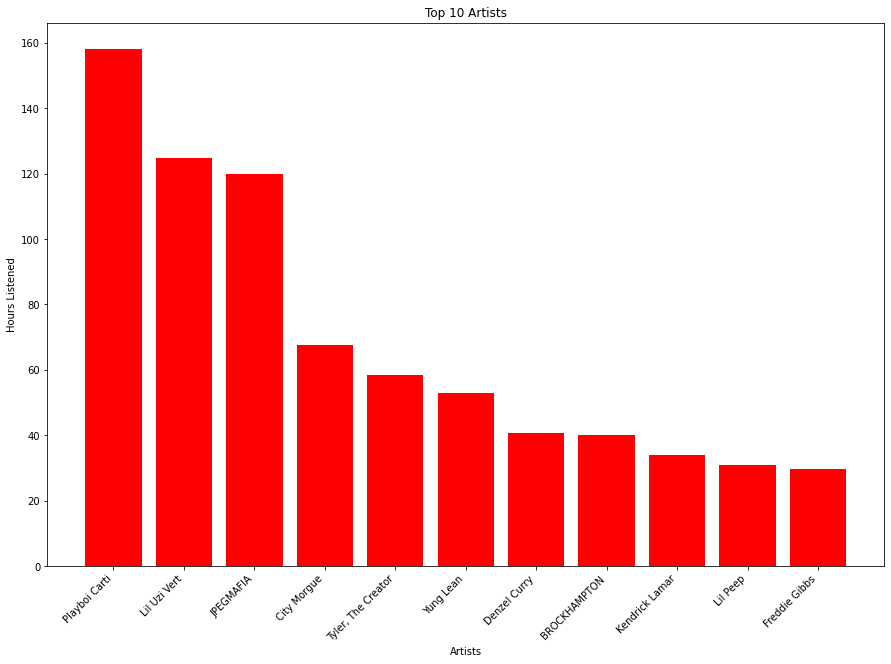

In [27]:
#artists 1-100
top_10_artists = artist_x_hours_df.iloc[0:11]
through_20_artists = artist_x_hours_df.iloc[11:21].reset_index()
through_30_artists = artist_x_hours_df.iloc[21:31].reset_index()
through_40_artists = artist_x_hours_df.iloc[31:41].reset_index()
through_50_artists = artist_x_hours_df.iloc[41:51].reset_index()
through_60_artists = artist_x_hours_df.iloc[51:61].reset_index()
through_70_artists = artist_x_hours_df.iloc[61:71].reset_index()
through_80_artists = artist_x_hours_df.iloc[71:81].reset_index()
through_90_artists = artist_x_hours_df.iloc[81:91].reset_index()
through_100_artists = artist_x_hours_df.iloc[91:101].reset_index()

#plots
utils.artist_bar_chart(top_10_artists, "1-10", "Top 10 Artists")
utils.artist_bar_chart(through_20_artists, "11-20", "Artist Rankings: 11-20")
utils.artist_bar_chart(through_30_artists, "21-30", "Artist Rankings: 21-30")
utils.artist_bar_chart(through_40_artists, "31-40", "Artist Rankings: 31-40")
utils.artist_bar_chart(through_50_artists, "41-50", "Artist Rankings: 41-50")
utils.artist_bar_chart(through_60_artists, "51-60", "Artist Rankings: 51-60")
utils.artist_bar_chart(through_70_artists, "61-70", "Artist Rankings: 61-70")
utils.artist_bar_chart(through_80_artists, "71-80", "Artist Rankings: 71-80")
utils.artist_bar_chart(through_90_artists, "81-90", "Artist Rankings: 81-90")
utils.artist_bar_chart(through_100_artists, "91-100", "Artist Rankings: 91-100")

Carti, Uzi, and Peggy dominated my listening time.

#### Percentage of Listening: Top 100 or not?

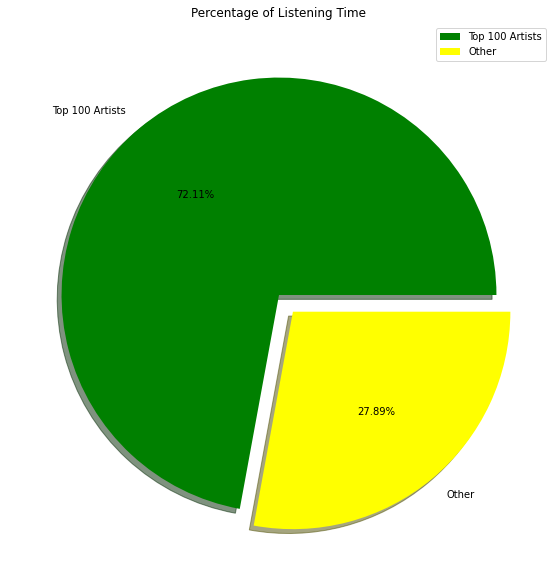

In [28]:
msPlayed_top100 = 0
msPlayed_non100 = 0
msPlayedList = timeListen.to_list()

i=0
while i in range(len(top100YorN)):
    if top100YorN[i] == 'y':
        msPlayed_top100 += msPlayedList[i]
    else:
        msPlayed_non100 += msPlayedList[i]
    i+=1

plt.figure(figsize=(15,10))
x = ["Top 100 Artists", "Other"]
y = [msPlayed_top100/(msPlayed_top100+msPlayed_non100), msPlayed_non100/(msPlayed_top100+msPlayed_non100)]
plt.pie(y, labels=x, autopct="%1.2f%%", colors=['green', 'yellow'], shadow=True, explode= (0, 0.1))
plt.title("Percentage of Listening Time")
plt.savefig("Figures/percentageofmusic.png")
plt.legend()
plt.show()

A majority of my listening was spent listening to my Top 100 artists. Nearly 72% of my listening time was spend listening to 6% of my library of artists. Perhaps I should vary it up a little bit.

#### Average Listening Hours for Day of Week

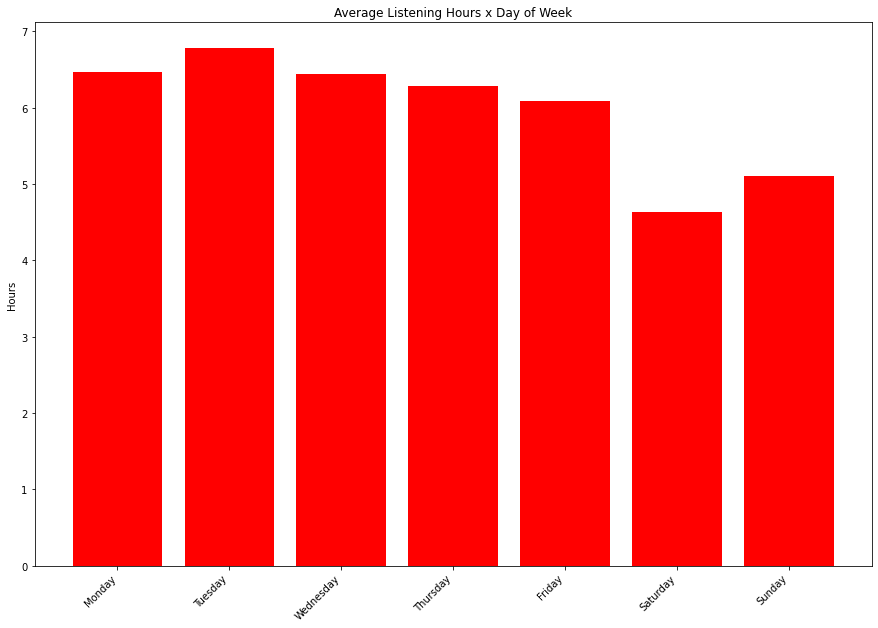

In [31]:
import numpy as np

group_by_weekday_df = spot_df.groupby("day", sort=False)
plt.figure(figsize=(15,10))
for group_name, group_df in group_by_weekday_df:
    msplayed_ser = group_df["msPlayed"].copy()
    totalms = msplayed_ser.sum()
    total_hours = totalms/1000/60/60/52
    plt.bar(group_name, total_hours,color="red")

plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Average Listening Hours x Day of Week")
plt.ylabel("Hours")
plt.savefig("Figures/averagelistening_per_dayofweek.png")
plt.show()

My average listening time seemed to hober between 6-7 hours, but dropped dramatically over the weekend, which was unexpected. It seems I listen to more music when I have classes; it is possible this is due to an increase in online activity with the pandemic, drawing me toward spotify.

---

## Classification Results

## Conclusion